In [1]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
from cnn.cnn1d import ConvAutoencoder,data_to_tensor
from dynamic_thresholds import compute_rolling_vol, calc_vol_thershold, vol_regimes, compute_dynamic_thresholds, detect_anomalies_sample, detect_anomalies_index
import matplotlib.pyplot as plt 

def compute_rolling_volume(data: pd.DataFrame, window_size: int=20):
    vol_df = data.rolling(window=window_size).mean().dropna()
    return vol_df

def cnn_predict(model ,data: pd.DataFrame ,seq_n: int):
    sample_index = data.shift(seq_n - 1).dropna().index.tolist()
    data_list = []
    for sample in sample_index:
        data_list.append(data_to_tensor(data.loc[:sample].iloc[-seq_n:].T))
        
    y_pred = []
    for X_i in data_list:
        with torch.no_grad():
            y_i = model(X_i).detach().cpu().numpy().T
            y_pred.append(y_i)
    y_true = np.array([x.cpu().numpy().T for x in data_list])
    return np.array(y_pred), y_true

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

mid_cap_index = pd.read_csv('data/mid_cap_all_sectors_ret.csv', index_col='date')
volume = np.log(pd.read_csv('data/mid_cap_all_sectors_volume.csv', index_col='date'))

ret = mid_cap_index * 100
n = int(len(ret) * 0.8)
train_n = int(n * 0.8)
tmp = ret.iloc[:n]
train_df = tmp.iloc[:train_n]
valid_df = tmp.iloc[train_n:]
test_df = ret.iloc[n:]

tmp_volume = volume.iloc[:n]
valid_volume = tmp_volume.iloc[train_n:]
test_volume = volume.iloc[n:]

print(f"train_df shape: {train_df.shape}; valid_df shape: {valid_df.shape};test_df shape: {test_df.shape};")
print(f" valid_df shape: {valid_volume.shape};test_df shape: {test_volume.shape};")

train_df shape: (3970, 11); valid_df shape: (993, 11);test_df shape: (1241, 11);
 valid_df shape: (993, 11);test_df shape: (1241, 11);


In [3]:
vol_df = compute_rolling_vol(data = valid_df, window_size=20)
volume_df = compute_rolling_volume(data=valid_volume, window_size=20)
volume_df

,Materials,Industrials,Health Care,Real Estate,Consumer Discretionary,Financials,Utilities,Information Technology,Energy,Consumer Staples,Communication Services
date,,,,,,,,,,,
2015-11-11,14.546291,13.545306,13.804733,13.524771,14.392403,13.843751,13.082078,13.624443,15.217393,13.562123,13.508911
2015-11-12,14.537642,13.556886,13.787448,13.531408,14.399245,13.844691,13.082045,13.615174,15.219249,13.577878,13.483668
2015-11-13,14.536727,13.558201,13.813105,13.534971,14.431575,13.848025,13.073787,13.610713,15.227727,13.595725,13.492497
2015-11-16,14.549261,13.556809,13.823395,13.535796,14.449624,13.851489,13.074498,13.602951,15.236379,13.613464,13.482254
2015-11-17,14.564366,13.550384,13.827142,13.536427,14.466627,13.847395,13.103709,13.585690,15.247853,13.628283,13.483451
...,...,...,...,...,...,...,...,...,...,...,...
2019-09-19,14.536532,13.256313,13.593587,13.732222,14.704597,13.791719,13.208350,13.589368,15.597187,13.919124,13.792361
2019-09-20,14.567401,13.306659,13.646355,13.785324,14.687347,13.852482,13.251307,13.623683,15.655058,13.940029,13.837017
2019-09-23,14.575289,13.295971,13.642144,13.782833,14.673606,13.851990,13.243353,13.619973,15.657414,13.927376,13.848869


In [4]:
input_dim = train_df.shape[1]
seq_n = 20
model_path = 'models_repo/2024_11_06_cnn1d_channel.pth'
model = ConvAutoencoder(in_channels = input_dim, 
                        hidden_channels1 = 64,
                        activation_func=nn.Tanh(),
                        kernel_size = 3,
                        stride = 2).to(device)
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

y_val_pred, y_val = cnn_predict(model = model,data = valid_df, seq_n = seq_n)
mae = np.mean(np.abs(y_val_pred - y_val), axis=1)
mae_df = pd.DataFrame(mae, index=valid_df.shift(seq_n-1).dropna().index, columns=valid_df.columns)

In [5]:
mae_df

,Materials,Industrials,Health Care,Real Estate,Consumer Discretionary,Financials,Utilities,Information Technology,Energy,Consumer Staples,Communication Services
date,,,,,,,,,,,
2015-11-11,0.363239,0.460943,0.129036,0.315175,0.525294,0.607922,0.302016,0.137205,0.203963,0.099591,0.143363
2015-11-12,0.352843,0.537371,0.169044,0.368368,0.575443,0.587450,0.357297,0.181124,0.210485,0.143928,0.147772
2015-11-13,0.476307,0.470127,0.139458,0.361586,0.588661,0.668786,0.242495,0.210489,0.194152,0.127824,0.179077
2015-11-16,0.455646,0.493009,0.180709,0.331730,0.601107,0.615255,0.320857,0.211841,0.230295,0.100852,0.152157
2015-11-17,0.478318,0.481051,0.153645,0.344317,0.628873,0.605620,0.345292,0.175550,0.216350,0.173318,0.168939
...,...,...,...,...,...,...,...,...,...,...,...
2019-09-19,0.241214,0.178260,0.135250,0.285207,0.411836,0.474285,0.193517,0.173879,0.376933,0.163080,0.116792
2019-09-20,0.253913,0.202548,0.130284,0.318903,0.368551,0.474641,0.163202,0.156998,0.341274,0.178240,0.203805
2019-09-23,0.199219,0.184862,0.149374,0.287271,0.305985,0.458080,0.139683,0.182923,0.374653,0.116133,0.117877


In [6]:
def OLS(x, y):
    X = np.concatenate([np.ones([len(x), 1]), x], axis=1)
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta

In [7]:
beta_dict = {}
for sector in mae_df.columns:
    sector_mae = mae_df.loc[:, sector]
    sector_vol = vol_df.loc[:, sector]
    sector_volume = volume_df.loc[:, sector]

    y = np.array(sector_mae)
    X = np.vstack([sector_vol, sector_volume]).T

    beta_dict[sector] = OLS(X,y)

In [8]:
beta_dict

{'Materials': array([-1.35583658,  0.06120739,  0.10831079]),
 'Industrials': array([-2.48153371,  0.08528842,  0.19996892]),
 'Health Care': array([-0.18383208,  0.0938079 ,  0.01426163]),
 'Real Estate': array([-0.49663861,  0.12156841,  0.05135977]),
 'Consumer Discretionary': array([-1.00259836,  0.1255052 ,  0.08360965]),
 'Financials': array([-1.54466014,  0.19100068,  0.13247666]),
 'Utilities': array([-0.39236381,  0.14944881,  0.03626143]),
 'Information Technology': array([ 0.39136208,  0.08445067, -0.02571743]),
 'Energy': array([-0.05574728,  0.10994156,  0.00075424]),
 'Consumer Staples': array([ 0.15231508,  0.1240247 , -0.00991918]),
 'Communication Services': array([ 0.06253162,  0.09869531, -0.00512719])}

In [9]:
mae_res = pd.DataFrame(index=mae_df.index, columns=mae_df.columns)
for sector in mae_df.columns:
    sector_mae = mae_df.loc[:, sector]
    sector_vol = vol_df.loc[:, sector]
    sector_volume = volume_df.loc[:, sector]

    y = np.array(sector_mae)
    X = np.vstack([sector_vol, sector_volume]).T
    X = np.concatenate([np.ones((X.shape[0],1)), X],axis=1)

    mae_res.loc[:, sector] = y - X @ beta_dict[sector]

In [10]:
mae_res

,Materials,Industrials,Health Care,Real Estate,Consumer Discretionary,Financials,Utilities,Information Technology,Energy,Consumer Staples,Communication Services
date,,,,,,,,,,,
2015-11-11,0.06555,0.131716,-0.049874,-0.00569,0.196795,0.0796,0.039405,-0.019694,-0.030272,-0.04733,-0.005743
2015-11-12,0.047272,0.191246,-0.020671,0.048007,0.244242,0.045803,0.099083,0.019467,-0.020831,-0.035664,-0.003072
2015-11-13,0.170582,0.125083,-0.051253,0.040241,0.233104,0.12235,-0.015353,0.047318,-0.048001,-0.045895,0.027489
2015-11-16,0.147624,0.145702,-0.010131,0.010942,0.24001,0.064919,0.047526,0.047166,-0.022163,-0.074136,-0.0037
2015-11-17,0.167338,0.134549,-0.033999,0.02347,0.266241,0.056698,0.063459,0.011603,-0.043609,-0.000934,0.014477
...,...,...,...,...,...,...,...,...,...,...,...
2019-09-19,-0.068871,-0.102277,0.01607,-0.01048,-0.009987,-0.042382,-0.011489,0.003805,0.004859,0.021207,-0.038356
2019-09-20,-0.058691,-0.088351,0.013435,0.021735,-0.051005,-0.05147,-0.043295,-0.014754,-0.028621,0.04167,0.049224
2019-09-23,-0.103968,-0.08142,0.049668,0.006565,-0.07451,-0.017228,-0.043176,0.033832,0.022859,-0.005249,-0.026649


In [11]:
thres_dict = {}
for sector in mae_res:
    sector_mae = mae_res.loc[:, sector]
    threshold = np.quantile(np.abs(sector_mae), 0.95)
    thres_dict[sector] = threshold


In [12]:
thres_dict

{'Materials': 0.09540270715616474,
 'Industrials': 0.09798812650639625,
 'Health Care': 0.05214641636479356,
 'Real Estate': 0.10344203402224869,
 'Consumer Discretionary': 0.10657475201133361,
 'Financials': 0.14760550436696604,
 'Utilities': 0.07949014778113371,
 'Information Technology': 0.06887245971742338,
 'Energy': 0.06551162284784558,
 'Consumer Staples': 0.05742335506462538,
 'Communication Services': 0.04504984389062192}

In [13]:
y_out_sample_pred, y_out_sample = cnn_predict(model = model,data = test_df, seq_n = seq_n)
out_sample_mae = np.mean(np.abs(y_out_sample_pred - y_out_sample), axis=1)
out_sample_mae_df = pd.DataFrame(out_sample_mae, index=test_df.shift(seq_n-1).dropna().index, columns=test_df.columns)

In [14]:
outsamle_vol_df = compute_rolling_vol(data = test_df, window_size=20)
outsamle_volume_df = compute_rolling_volume(data=test_volume, window_size=20)
outsamle_volume_df

,Materials,Industrials,Health Care,Real Estate,Consumer Discretionary,Financials,Utilities,Information Technology,Energy,Consumer Staples,Communication Services
date,,,,,,,,,,,
2019-10-23,14.737936,13.174776,13.498526,13.641127,14.363278,13.749757,13.065477,13.447649,15.374208,13.678122,13.661799
2019-10-24,14.758588,13.177990,13.480432,13.645482,14.360758,13.751771,13.060500,13.451003,15.371936,13.666301,13.658604
2019-10-25,14.776081,13.179769,13.477725,13.648504,14.353810,13.747953,13.049972,13.445507,15.382952,13.652780,13.656452
2019-10-28,14.785220,13.183004,13.476077,13.651455,14.339049,13.753339,13.039995,13.447431,15.379891,13.644916,13.651696
2019-10-29,14.766074,13.194042,13.478144,13.674686,14.333546,13.752092,13.043624,13.457269,15.386104,13.632811,13.630656
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,14.410014,13.353401,14.228952,14.071559,14.283594,13.893412,13.331286,14.019139,14.883708,14.253010,14.473188
2024-08-27,14.404106,13.332124,14.195596,14.058297,14.275292,13.867983,13.315223,13.990444,14.851475,14.240783,14.459748
2024-08-28,14.384146,13.306307,14.171217,14.030118,14.269711,13.831835,13.289459,13.977791,14.820488,14.232116,14.438192


In [15]:
# outsample_mae_res = pd.DataFrame(index=out_sample_mae_df.index, columns=out_sample_mae_df.columns)
# for sector in outsample_mae_res.columns:
#     sector_mae = out_sample_mae_df.loc[:, sector]
#     sector_vol = outsamle_vol_df.loc[:, sector]
#     sector_volume = outsamle_volume_df.loc[:, sector]

#     y = np.array(sector_mae)
#     X = np.vstack([sector_vol, sector_volume]).T
#     beta = OLS(X, y)
#     X = np.concatenate([np.ones((X.shape[0],1)), X],axis=1)
#     outsample_mae_res.loc[:, sector] = y - X @ beta

In [16]:
outsample_mae_res = pd.DataFrame(index=out_sample_mae_df.index, columns=out_sample_mae_df.columns)
for sector in outsample_mae_res.columns:
    sector_mae = out_sample_mae_df.loc[:, sector]
    sector_vol = outsamle_vol_df.loc[:, sector]
    sector_volume = outsamle_volume_df.loc[:, sector]

    y = np.array(sector_mae)
    X = np.vstack([sector_vol, sector_volume]).T
    X = np.concatenate([np.ones((X.shape[0],1)), X],axis=1)

    outsample_mae_res.loc[:, sector] = y - X @ beta_dict[sector]

In [17]:
outsample_mae_res

,Materials,Industrials,Health Care,Real Estate,Consumer Discretionary,Financials,Utilities,Information Technology,Energy,Consumer Staples,Communication Services
date,,,,,,,,,,,
2019-10-23,-0.120805,0.019961,-0.032885,-0.009691,-0.030029,-0.06149,-0.052913,-0.02685,-0.022795,-0.011874,0.007229
2019-10-24,-0.08047,-0.02346,0.031466,0.023136,-0.047336,-0.082284,-0.016444,-0.009559,-0.00705,0.020488,-0.003068
2019-10-25,-0.092308,-0.021506,-0.022059,-0.00425,-0.031146,-0.088067,0.004662,-0.042323,-0.041377,-0.016944,-0.009373
2019-10-28,-0.02332,-0.028433,0.009429,0.026876,-0.039807,-0.094404,0.028305,-0.02843,-0.046887,-0.005561,-0.019994
2019-10-29,-0.057262,-0.033467,0.016081,-0.015491,-0.01195,-0.062919,-0.021706,-0.001539,0.022649,-0.004725,0.001421
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,-0.000276,-0.079833,0.014604,-0.051592,-0.065416,-0.079246,-0.028948,0.044411,0.032576,-0.007154,-0.00908
2024-08-27,-0.044873,-0.048299,0.013958,-0.049612,-0.076593,-0.095828,-0.020163,-0.030888,0.042025,-0.038777,0.012328
2024-08-28,-0.109935,-0.072108,0.006804,-0.025657,-0.05609,-0.040896,-0.035305,0.006362,-0.002491,-0.023173,-0.010798


In [18]:
# anomalies = pd.DataFrame(False, index=outsample_mae_res.index, columns=outsample_mae_res.columns)

# for sector in anomalies.columns:
#     setor_score = outsample_mae_res[sector]
#     threshold = thres_dict[sector]
#     diff = setor_score - threshold
#     diff = diff.astype(float)
#     if len(diff) > 150:
#         top_indices = diff.nlargest(150).index
#     else:
#         top_indices = diff.index
#     anomalies.loc[top_indices, sector] = (np.abs(setor_score[top_indices]) > threshold).astype(bool)

#     print((anomalies.iloc[:, anomalies.columns.get_loc(sector)] == 1).sum())

In [19]:
anomalies = pd.DataFrame(False, index=outsample_mae_res.index, columns=outsample_mae_res.columns)

for sector in anomalies.columns:
    setor_score = outsample_mae_res[sector]
    threshold = thres_dict[sector]
    anomalies.iloc[:, anomalies.columns.get_loc(sector)] = (np.abs(setor_score) > threshold).astype(bool)






In [20]:
def detect_anomalies_index(data: pd.DataFrame, anomalies_df: pd.DataFrame, seq_n: int, weight_on_seq: float):
    threshold = int(seq_n * weight_on_seq)

    anomalies_index = {}
    for i, sector in enumerate(anomalies_df.columns):
        sector_anomalies = anomalies_df.iloc[:, i]
        anomalies_index[sector] = []
        for data_idx in range(seq_n - 1, len(data) - seq_n + 1):
            anomaly_count = sector_anomalies.iloc[data_idx - seq_n + 1: data_idx + 1].sum()
            if anomaly_count >= threshold: 
                anomalies_index[sector].append(data_idx)

    return anomalies_index

anomalies_index = detect_anomalies_index(test_df, anomalies, 20, 0.95)

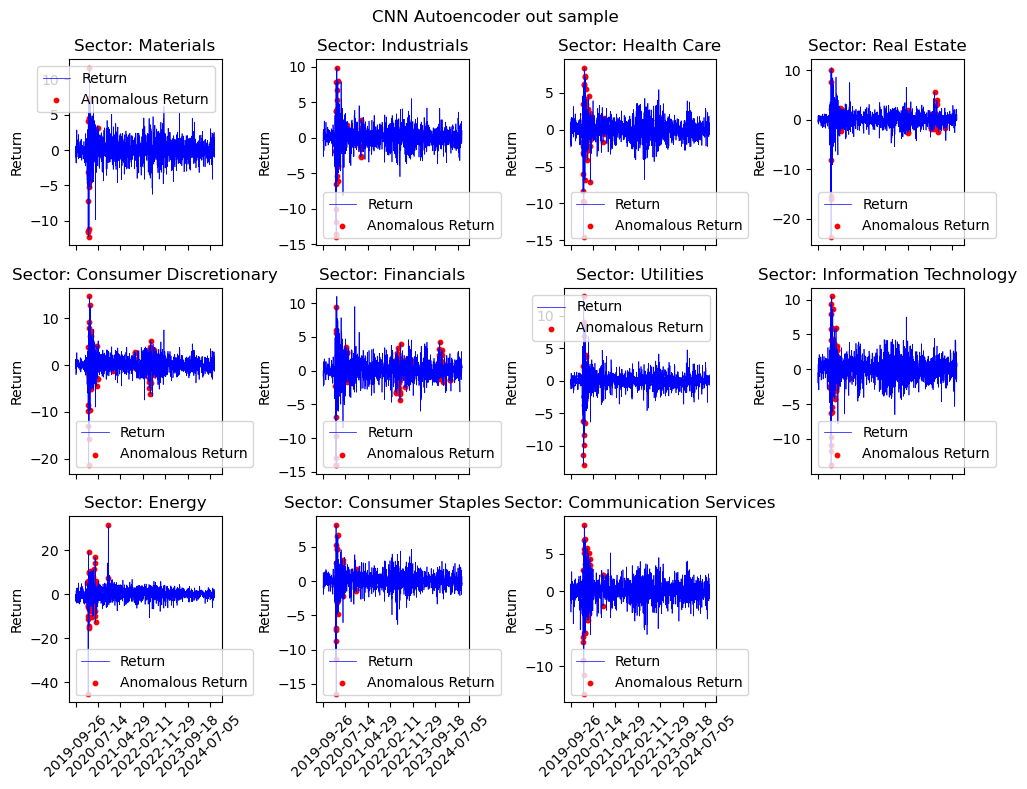

In [21]:
fig, axes = plt.subplots(3, 4, figsize=(10, 8), sharex=True) 
axes = axes.flatten()
for i, column_name in enumerate(test_df.columns):
    axes[i].plot(test_df[column_name], label="Return", color="blue", linewidth=0.5) 
    anomalous_indices = anomalies_index.get(column_name, [])
    axes[i].scatter(anomalous_indices, test_df.iloc[anomalous_indices][column_name], color="red", label="Anomalous Return", s=10)
    
    axes[i].set_title(f"Sector: {column_name}")
    axes[i].set_ylabel("Return")
    axes[i].legend()
    
    axes[i].set_xticks(np.arange(0, len(test_df), 200))
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(test_df.columns), 12):
    fig.delaxes(axes[j])
plt.suptitle('CNN Autoencoder out sample')
plt.tight_layout()
plt.savefig('tmp.png')
plt.show()

In [22]:
output = pd.DataFrame(0, index=test_df.index, columns=test_df.columns)

for sector in anomalies_index.keys():
    index = anomalies_index[sector]
    output.iloc[index, output.columns.get_loc(sector)] = 1

In [23]:
for sector in output.columns:
    print(f"{sector} count : {output.loc[:, sector].sum()}")
print(output.sum().sum())

Materials count : 15
Industrials count : 35
Health Care count : 80
Real Estate count : 83
Consumer Discretionary count : 84
Financials count : 124
Utilities count : 23
Information Technology count : 71
Energy count : 80
Consumer Staples count : 30
Communication Services count : 75
700


In [24]:
pd.read_csv('cnn.csv', index_col='date').sum().sum()

853